# Paediatric X-ray image Classification


---

# Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score

from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from time import process_time
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [78]:
# Some useful functions

"""
Arguments: takes a keras model instance that has been trained to a set of data

Output: returns 2 plots, the first of which is a plot of the models training loss vs validation loss
        the second of which is a plot of the models training accuracy vs validation accuracy

Exceptions: no exceptions coded into this function
"""
def plot_progress(fitted_model):
    plt.style.use('ggplot')
    
    # calling the required values needed for the plots
    hist_cnn = fitted_model.history
    loss_values = hist_cnn['loss']
    val_loss_values = hist_cnn['val_loss']
    acc_values = hist_cnn['accuracy'] 
    val_acc_values = hist_cnn['val_accuracy']
    
    # asthetic variables for the plots
    epochs = range(1, len(loss_values) + 1)
    title_size = 20
    hex_red = '#800000'
    hex_orange = '#FFA500'
    hex_green = '#006400'
    hex_blue = '#008080'
    
    # plot of the loss history 
    plt.figure(figsize=(12,15))
    plt.subplot(211)
    plt.plot(epochs, loss_values, color=hex_red, linestyle='-.', label='Training loss')
    plt.plot(epochs, val_loss_values, color=hex_orange, label='Validation loss')
    plt.title('Model Loss', fontsize=title_size)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot of the accuracy history 
    plt.subplot(212)
    plt.plot(epochs, acc_values, color=hex_green, linestyle='-.', label='Training acc')
    plt.plot(epochs, val_acc_values, color=hex_blue, label='Validation acc')
    plt.title('Model Accuracy', fontsize=title_size)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # show both of the plots with some space between them
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [3]:
# creating an image generator for train, validation and test sets
train_direct = 'data/train'
val_direct = 'data/val'
test_direct = 'data/test'
batch_size = 128
height_width = 128 # using lower resolution values for decreased computational strain and faster training speeds
datagen = ImageDataGenerator(rescale=1/255)

# training image generator
train_data = datagen.flow_from_directory(directory=train_direct,
                                   batch_size=batch_size,
                                   target_size=(height_width, height_width),
                                   class_mode='binary',
                                   seed=42)

# validation image generator
val_data = datagen.flow_from_directory(directory=val_direct,
                                   batch_size=batch_size,
                                   target_size=(height_width, height_width),
                                   class_mode='binary',
                                   seed=42)

# test image generator
test_data = datagen.flow_from_directory(directory=test_direct,
                                   batch_size=batch_size,
                                   target_size=(height_width, height_width),
                                   class_mode='binary',
                                   seed=42)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
# producing the next batch of 128 images and their labels for training data
images, labels = next(train_data)

In [5]:
images.shape

(128, 128, 128, 3)

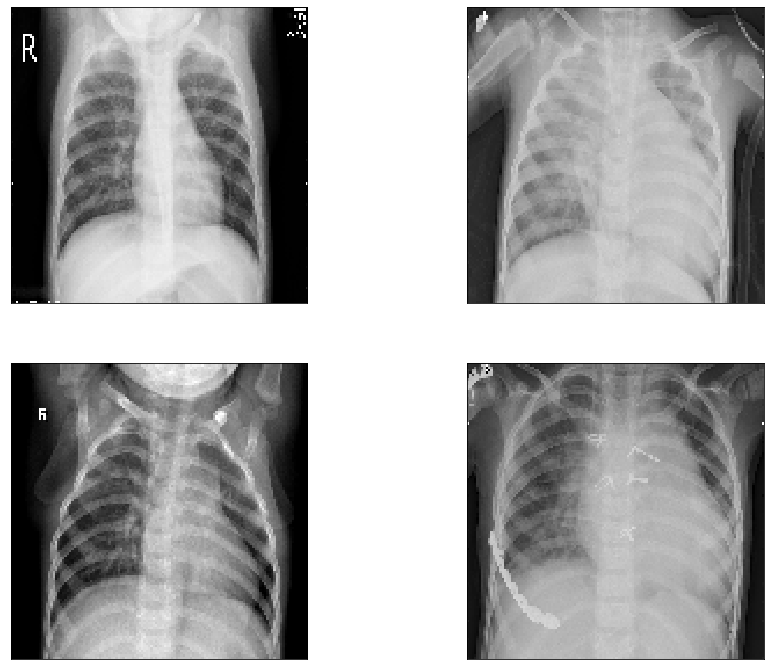

In [6]:
# quick inspection of the images

# small sample of 4 images
sample = images[::32]

# all 4 images shown with no axis ticks
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,12))
ax1.imshow(sample[0])
ax1.set_xticks([])
ax1.set_yticks([])
# ax1.set_title(sample_labl[0])

ax2.imshow(sample[1])
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(sample[2])
ax3.set_xticks([])
ax3.set_yticks([])

ax4.imshow(sample[3])
ax4.set_xticks([])
ax4.set_yticks([]);

In [7]:
# quick inspection of the labels
labels

array([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0.], dtype=float32)

### Thoughts on initial inspection:
Some of the images include details of the clothing worn by the patients as well as labels presumably for the use of the radiologists. I beleive that these minute details will not have an adverse effect on the models predictive power as long as the details offer no indication as to what class each image belongs to, which will lead to the neural net fitting to those details as apposed to generalising the trends in the xrays of the patients themselves

### Thoughts on sample sizes:
- Training set size and split between classes
- Validation set size and split between classes
- Test set size and split between classes
- What is the prevalence of the data set?

# Modelling

## Baseline Model

In [8]:
# building a very simple baseline convolutional network with maximum 16 nodes to increase computational speed 

base_cnn = models.Sequential() # simple feed-forward architecture
base_cnn.add(layers.Conv2D(8, input_shape=(height_width, height_width, 3), kernel_size=(3,3), activation='relu'))
base_cnn.add(layers.MaxPooling2D(pool_size = (2,2)))
base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(8, activation='relu'))
base_cnn.add(layers.Dense(1, activation='sigmoid')) # binary output of class prediction


base_cnn.compile(optimizer='adam', # cost function used to minimise overall model inaccuracy
                loss='binary_crossentropy', # loss function applicable to a binary classification
                metrics=['accuracy']) # a calculation of the %tage of correct predictions out of all the models predictions

base_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 254024    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 254,257
Trainable params: 254,257
Non-trainable params: 0
_________________________________________________________________


In [9]:
train_step_size = train_data.n // batch_size
val_step_size = val_data.n // batch_size
epochs = 2

start_time = process_time() # stopwatch timer started
base_cnn_hist = base_cnn.fit_generator(train_data,
                       steps_per_epoch=train_step_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=val_data,
                       validation_steps=val_step_size);
stop_time = process_time() # stopwatch timer ended


total_min = np.floor((stop_time-start_time)/ 60) # number of minutes to train
remain_sec = np.round((stop_time-start_time)% 60) # number of seconds to train
print('------------------------------------------------------------------------------------------------------------------')
print(f'Time to train: {int(total_min)} mins {int(remain_sec)} secs')

Epoch 1/2
40/40 [==============================] - 84s 2s/step - loss: 0.7124 - accuracy: 0.7258 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/2
40/40 [==============================] - 82s 2s/step - loss: 0.6812 - accuracy: 0.7437 - val_loss: 0.6938 - val_accuracy: 0.5000
------------------------------------------------------------------------------------------------------------------
Time to train: 6 mins 47 secs


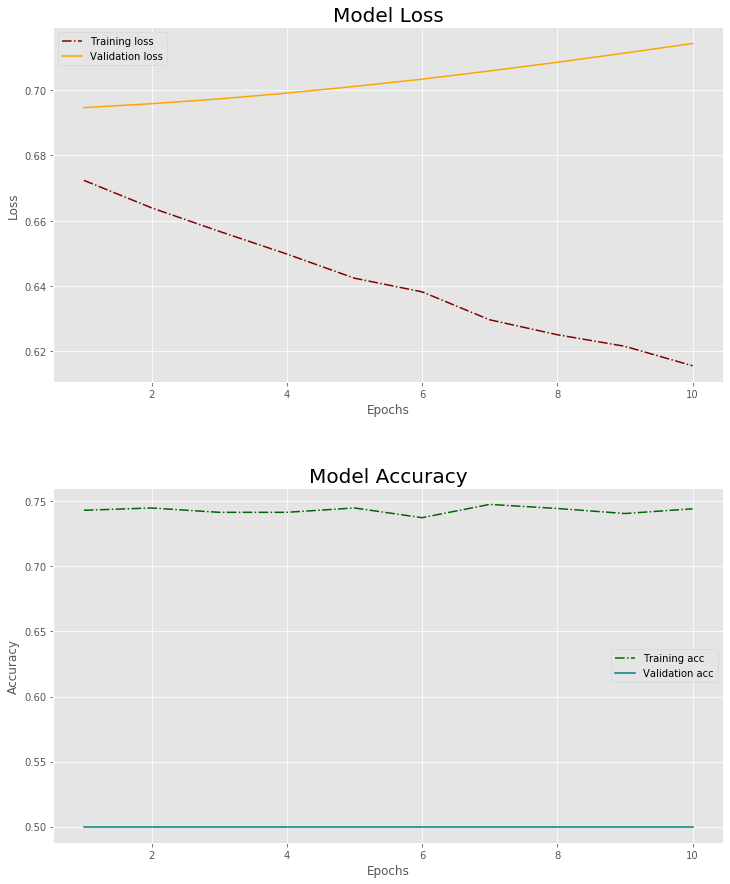

In [80]:
plot_progress(base_cnn_hist)

In [66]:
# all_train_labels = train_data.labels
# base_pred_train = base_cnn.predict_generator(train_data,
#                                              steps=train_step_size,
#                                              verbose=1)


# base_fpr_train, base_tpr_train, base_thresh_train = roc_curve(all_train_labels, base_pred_train)

# # base_pred_test = opt_model_base.predict_proba(X_test)[:,1]
# # base_fpr_test, base_tpr_test, base_thresh_test = roc_curve(y_test, base_pred_test)

In [50]:
# plt.style.use('ggplot')
# plt.figure(figsize=(12,7))
# ax1 = sns.lineplot(base_fpr_train, base_tpr_train, label='train',)
# ax1.lines[0].set_color("orange")
# ax1.lines[0].set_linewidth(2)

# ax2 = sns.lineplot(base_fpr_test, base_tpr_test, label='test')
# ax2.lines[1].set_color("yellow")
# ax2.lines[1].set_linewidth(2)

# ax3 = sns.lineplot([0,1], [0,1], label='baseline')
# ax3.lines[2].set_linestyle("--")
# ax3.lines[2].set_color("black")
# ax3.lines[2].set_linewidth(2)

# plt.title('Naive Bayes ROC Curve', fontsize=20)
# plt.xlabel('FPR', fontsize=16)
# plt.ylabel('TPR', fontsize=16)
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.text(x=0.8, y=0.8, s="50-50 guess", fontsize=14,
#          bbox=dict(facecolor='whitesmoke', boxstyle="round, pad=0.4"))

# plt.legend(loc=4, fontsize=17)
# plt.show();

### Thoughts on the baseline model:
- Model Loss: the training loss has a consistant decrease with each epoch but very early on we see a drastic increase in the validation loss. This is a clear sign of overfitting 

- Model accuracy: the training accuracy is much higher than expected at ~75% but the validation accuracy is very low at ~50%. Considering the images were generated at lower resolutions and the model is almost as simple as possible with few nodes and very few layers; I am not surprised by the validation accuracy here. This may also have a lot to do with the incredibly small validation set size <br> Maybe more importantly both the train and validation accuracy barely increase with each epoch. This is very very likely due to the learner getting stuck in a local minima 

- Train time: as expected the time to train only took a ~6 minutes even though I had not use a discrete graphics card

*Conclusion:* <br>
I have a feeling the validation set is too small to really make meaningful comparisons with the models perfomance on the training data versus its performance on the validation data. The implementation of only 2 epochs also makes comparison a bit more difficult but the purpose of this model was to have a base line that functions and nothing more. Besides that the disparity between the training and validation accuracy seems to be a sign of overfitting and the lack of improvemnt in the accuracy is a sign of the learner getting stuck in a local minima
<br><br>
*Next iteration:* <br>
before making any adjustments based on over/underfitting or local minimas, I would like to see the models performance with a more reasonable number of epochs. 10 epochs will give a much better idea of whats going on

## Model 2

In [67]:
# Same arhcitecture as the baseline model

cnn2 = models.Sequential() # simple feed-forward architecture
cnn2.add(layers.Conv2D(8, input_shape=(height_width, height_width, 3), kernel_size=(3,3), activation='relu'))
cnn2.add(layers.MaxPooling2D(pool_size = (2,2)))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(8, activation='relu'))
cnn2.add(layers.Dense(1, activation='sigmoid')) # binary output of class prediction


cnn2.compile(optimizer='adam', # cost function used to minimise overall model inaccuracy
                loss='binary_crossentropy', # loss function applicable to a binary classification
                metrics=['accuracy']) # a calculation of the %tage of correct predictions out of all the models predictions

cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 8)       224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 31752)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 254024    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 254,257
Trainable params: 254,257
Non-trainable params: 0
_________________________________________________________________


In [75]:
# now increasing the number of epochs to 10

train_step_size = train_data.n // batch_size
val_step_size = val_data.n // batch_size
epochs = 10

start_time = process_time() # stopwatch timer started
cnn2_hist = cnn2.fit_generator(train_data,
                       steps_per_epoch=train_step_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=val_data,
                       validation_steps=val_step_size);
stop_time = process_time() # stopwatch timer ended


total_min = np.floor((stop_time-start_time)/ 60) # number of minutes to train
remain_sec = np.round((stop_time-start_time)% 60) # number of seconds to train
print('------------------------------------------------------------------------------------------------------------------')
print(f'Time to train: {int(total_min)} mins {int(remain_sec)} secs')

Epoch 1/10
40/40 [==============================] - 90s 2s/step - loss: 0.3811 - accuracy: 0.8335 - val_loss: 0.6586 - val_accuracy: 0.6875
Epoch 2/10
40/40 [==============================] - 96s 2s/step - loss: 0.1886 - accuracy: 0.9254 - val_loss: 0.3902 - val_accuracy: 0.8750
Epoch 3/10
40/40 [==============================] - 90s 2s/step - loss: 0.1321 - accuracy: 0.9533 - val_loss: 0.6807 - val_accuracy: 0.6875
Epoch 4/10
40/40 [==============================] - 84s 2s/step - loss: 0.1342 - accuracy: 0.9456 - val_loss: 0.2935 - val_accuracy: 0.8750
Epoch 5/10
40/40 [==============================] - 84s 2s/step - loss: 0.0992 - accuracy: 0.9636 - val_loss: 0.3235 - val_accuracy: 0.8125
Epoch 6/10
40/40 [==============================] - 84s 2s/step - loss: 0.1053 - accuracy: 0.9586 - val_loss: 0.2134 - val_accuracy: 0.9375
Epoch 7/10
40/40 [==============================] - 84s 2s/step - loss: 0.1140 - accuracy: 0.9581 - val_loss: 0.2867 - val_accuracy: 0.8750
Epoch 8/10
40/40 [==

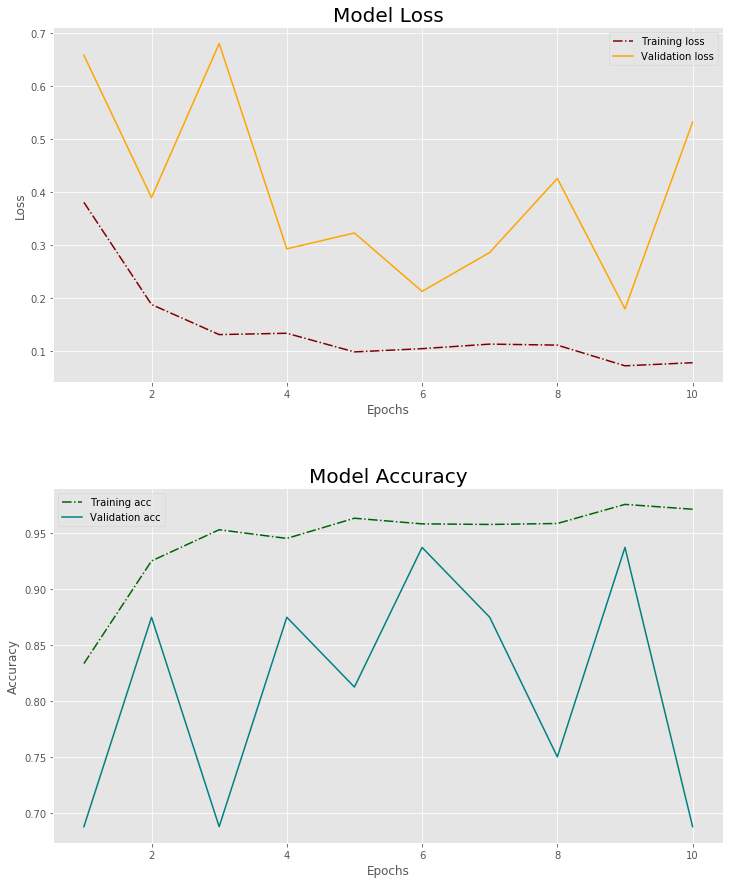

In [79]:
plot_progress(cnn2_hist)

### Thoughts on model 2:
- Model loss:
- Model accuracy: we can see that the training accuracy  
- Train time: time to train increased considerably but this is no surprise

*Conclusion:* <br>

<br><br>
*Next iteration:* <br>


# Conclusion